In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

In [4]:
PATH = Path('data/bulldozers')

In [5]:
df_raw = pd.read_feather(PATH/'df_raw_before_imputation')

x, y, nas = proc_df(df_raw, 'SalePrice')

def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

n_valid = 12000
n_train = df_raw.shape[0] - n_valid
df_raw_train, df_raw_val = split_vals(df_raw, n_train)
df_raw_train.shape, df_raw_val.shape

x_train, y_train, nas = proc_df(df_raw_train, 'SalePrice')

x_val, y_val, _ = proc_df(df_raw_val, 'SalePrice', na_dict=nas)

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m, x_train, y_train, x_val, y_val):
    print(f'Train rmse: {rmse(m.predict(x_train), y_train)}')
    print(f'Val rmse:   {rmse(m.predict(x_val), y_val)}')
    print(f'Train R^2:  {m.score(x_train, y_train)}')
    print(f'Val R^2:    {m.score(x_val, y_val)}')
    if hasattr(m, 'oob_score_'): print(f'OOB score:  {m.oob_score_}')

In [6]:
set_rf_samples(50000)

In [7]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.20557687290066567
Val rmse:   0.24721862673596104
Train R^2:  0.9116750628171747
Val R^2:    0.8908533644027253
OOB score:  0.8947102347187512


In [8]:
preds = np.stack([t.predict(x_val) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

(9.2414203100934, 0.2517626269553415)

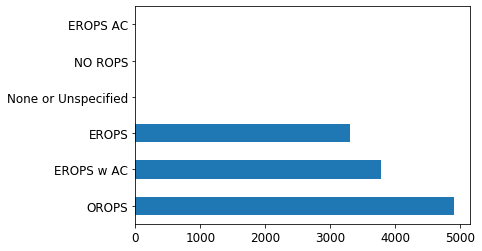

In [9]:
x = df_raw_val.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [10]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.840515,0.277043
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.576739,0.263794
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685923,0.223838


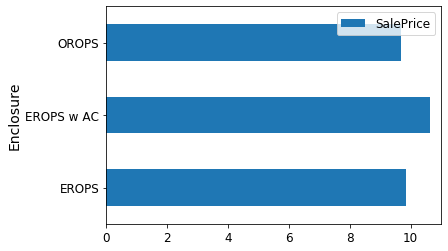

In [11]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

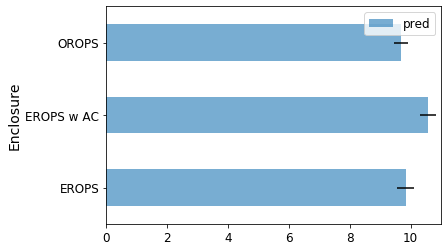

In [12]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

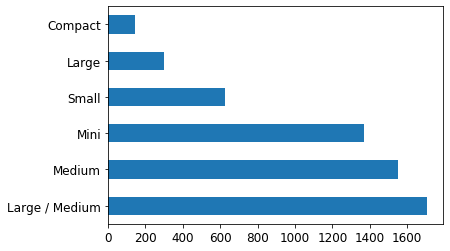

In [13]:
df_raw_val.ProductSize.value_counts().plot.barh();

In [14]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.875368,0.341784
Large,10.470589,10.371498,0.356641
Large / Medium,10.691871,10.646915,0.298335
Medium,10.681511,10.623691,0.284458
Mini,9.535147,9.567171,0.253876
Small,10.324448,10.320229,0.301801


In [15]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.034610
Large             0.034387
Small             0.029244
Large / Medium    0.028021
Medium            0.026776
Mini              0.026536
dtype: float64

In [16]:
(summ.pred_std/summ.pred).sort_values(ascending=True)

ProductSize
Mini              0.026536
Medium            0.026776
Large / Medium    0.028021
Small             0.029244
Large             0.034387
Compact           0.034610
dtype: float64

### Feature importance

In [17]:
fi = rf_feat_importance(m, x_train); fi[:10]

,cols,imp
5,YearMade,0.170968
37,Coupler_System,0.125557
13,ProductSize,0.097929
14,fiProductClassDesc,0.078606
2,ModelID,0.056744
63,saleElapsed,0.052058
10,fiSecondaryDesc,0.043295
38,Grouser_Tracks,0.036256
19,Enclosure,0.035900
39,Hydraulics_Flow,0.033696


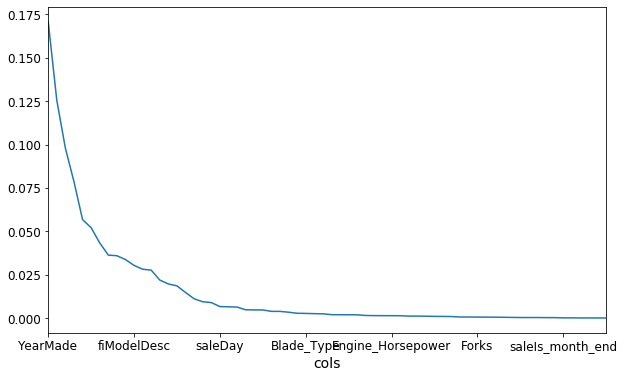

In [18]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [19]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

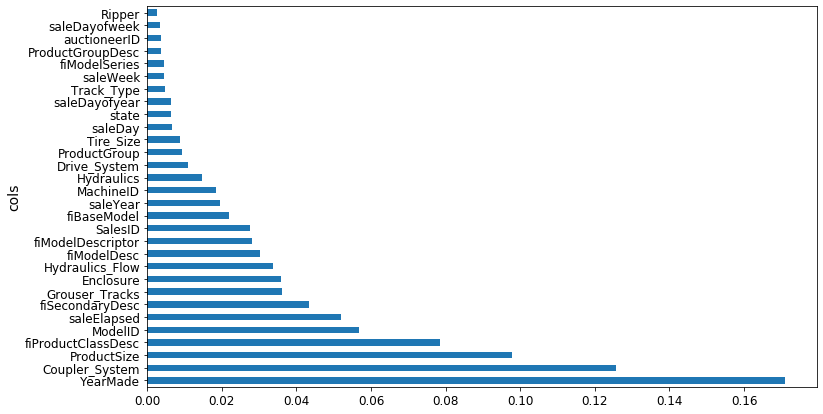

In [20]:
plot_fi(fi[:30]);

In [21]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [22]:
x_train_keep = x_train[to_keep].copy()
x_val_keep = x_val[to_keep].copy()

In [23]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(x_train_keep, y_train)
print_score(m, x_train_keep, y_train, x_val_keep, y_val)

Train rmse: 0.2068022669517105
Val rmse:   0.2451627720312905
Train R^2:  0.9106189573711864
Val R^2:    0.8926611296360406
OOB score:  0.8944023713186079


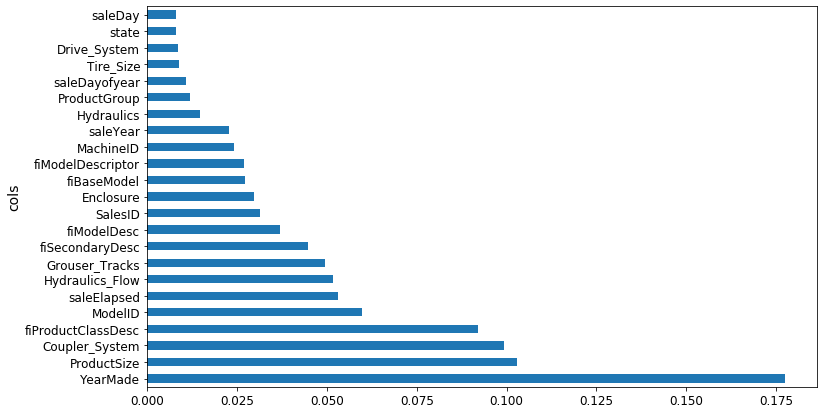

In [24]:
fi = rf_feat_importance(m, x_train_keep)
plot_fi(fi);

In [25]:
x_train, y_train, nas = proc_df(df_raw_train, 'SalePrice', max_n_cat=7)
x_val, y_val, _ = proc_df(df_raw_val, 'SalePrice', na_dict=nas, max_n_cat=7)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.20725320165635996
Val rmse:   0.2537065181223155
Train R^2:  0.9102287396291322
Val R^2:    0.8850494048504474
OOB score:  0.8924771432919406


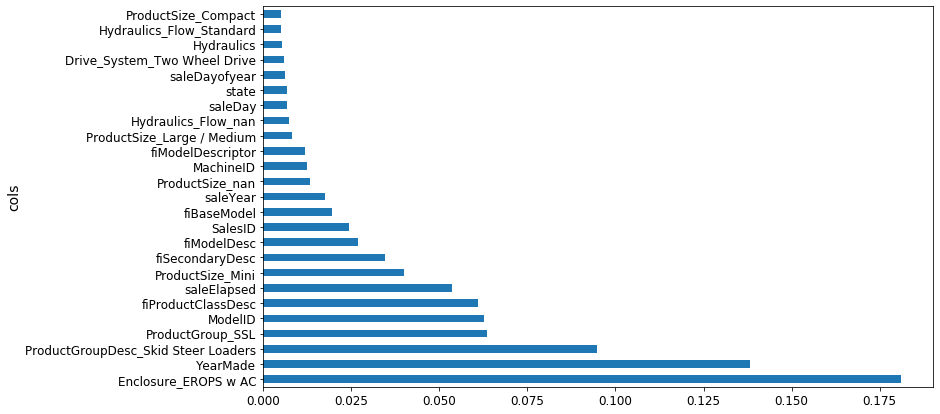

In [27]:
fi = rf_feat_importance(m, x_train)
plot_fi(fi[:25]);

### Removing redundant features

In [28]:
from scipy.cluster import hierarchy as hc

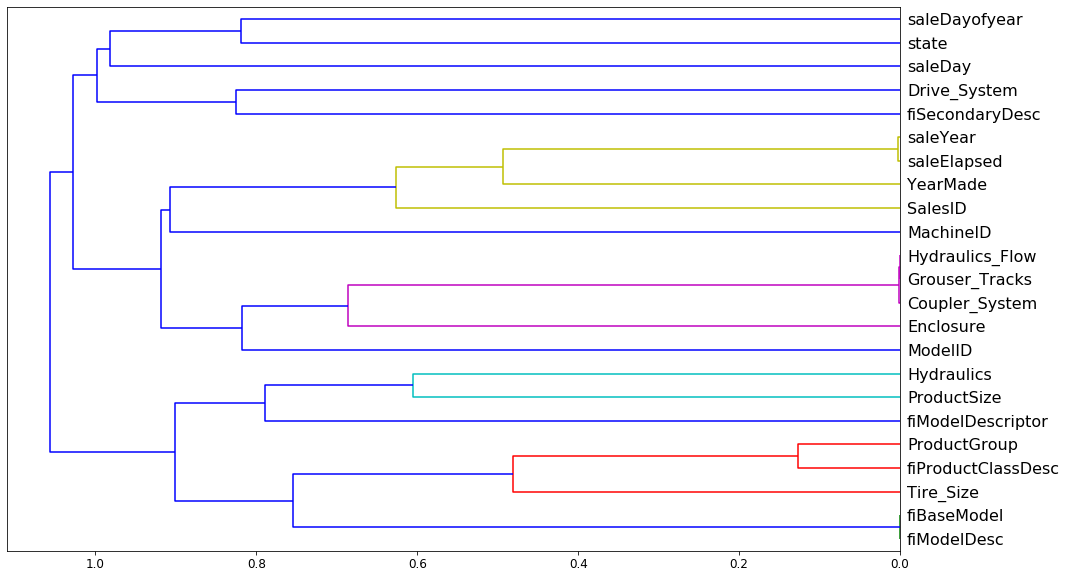

In [29]:
corr = np.round(scipy.stats.spearmanr(x_train_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=x_train_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [30]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_train)
    m.fit(x, y_train)
    return m.oob_score_

In [31]:
get_oob(x_train_keep)

0.8899392612669267

In [32]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(x_train_keep.drop(c, axis=1)))

saleYear 0.8885749233547648
saleElapsed 0.8868712417734365
fiModelDesc 0.8886959889376138
fiBaseModel 0.8893934952576987
Grouser_Tracks 0.8905607785537892
Coupler_System 0.8904297814543738


In [33]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(x_train_keep.drop(to_drop, axis=1))

0.8887750784936891

In [34]:
x_train_keep.drop(to_drop, axis=1, inplace=True)
x_val_keep.drop(to_drop, axis=1, inplace=True)

In [35]:
reset_rf_samples()

In [36]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train_keep, y_train)
print_score(m, x_train_keep, y_train, x_val_keep, y_val)

Train rmse: 0.12505287853036035
Val rmse:   0.22679611390600388
Train R^2:  0.9673169775644443
Val R^2:    0.9081415333849316
OOB score:  0.9086565995619447


### Partial Dependence

In [37]:
from pdpbox import pdp
from plotnine import *

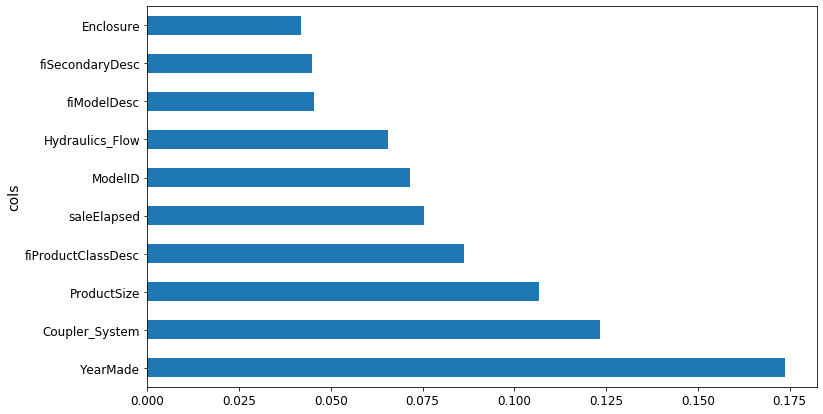

In [38]:
plot_fi(rf_feat_importance(m, x_train_keep)[:10]);

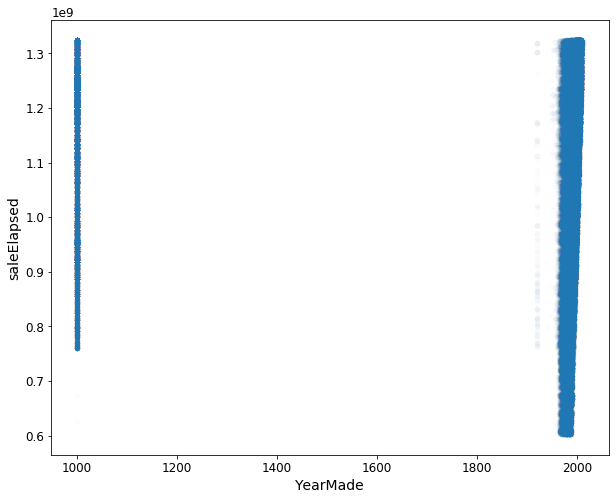

In [39]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [40]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

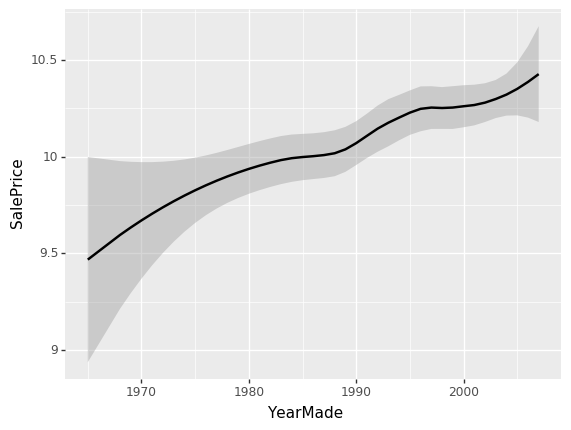

<ggplot: (-9223363301806855736)>

In [41]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [42]:
x = get_sample(x_train_keep[x_train_keep.YearMade>1930], 500)

In [43]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1cf712ba58>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1c958a42e8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


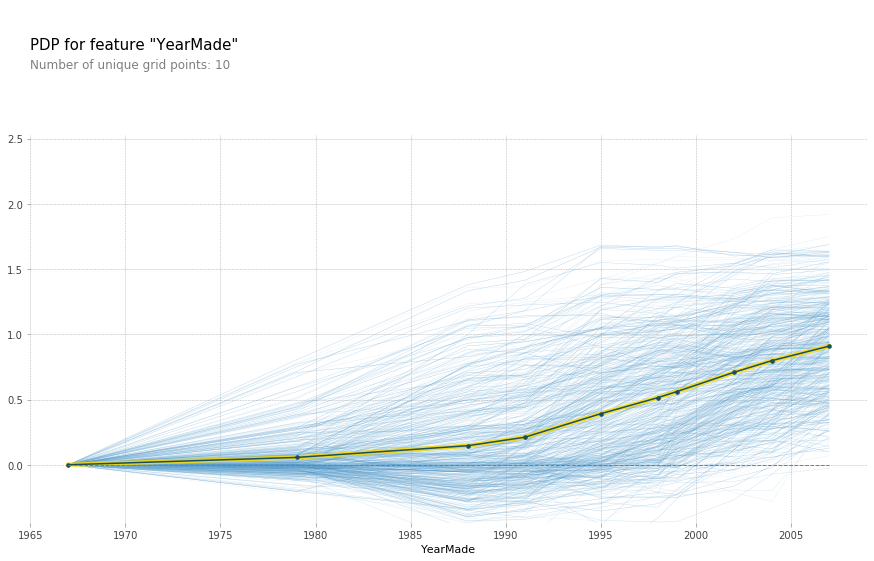

In [44]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1c93f45be0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1c93e9e9b0>})

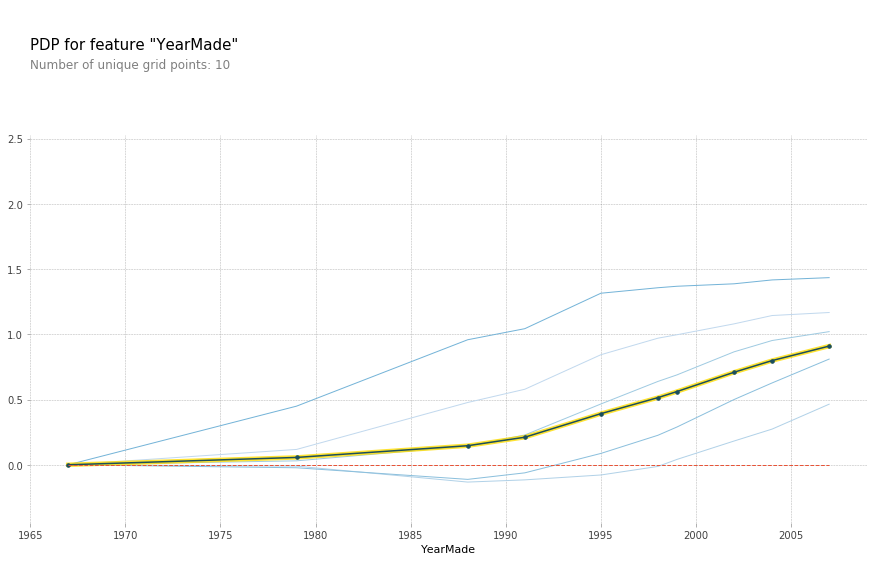

In [45]:
plot_pdp('YearMade', clusters=5)

### Tree Interpreter

In [46]:
from treeinterpreter import treeinterpreter as ti

In [47]:
df_train, df_valid = split_vals(df_raw[x_train_keep.columns], n_train)

In [48]:
row = x_val_keep.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          1,
                 0,       3232,          0,    4364751,    2300944,         12,          0,          4,
                 0,         16,         35,        259]])

In [49]:
prediction, bias, contributions = ti.predict(m, row)

In [50]:
prediction[0], bias[0]

(array([9.22975]), 10.10539676895415)

In [51]:
idxs = np.argsort(contributions[0])

In [52]:
[o for o in zip(x_train_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.6184480795284186),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.14816883299252667),
 ('saleElapsed', 1284595200, -0.08931840412986074),
 ('Enclosure', 'EROPS', -0.07568496311285933),
 ('fiModelDescriptor', nan, -0.06166731162951718),
 ('fiModelDesc', 'KX1212', -0.032161406151500094),
 ('ModelID', 665, -0.025201475409688933),
 ('SalesID', 4364751, -0.023195144828797698),
 ('MachineID', 2300944, -0.01620083786291966),
 ('Tire_Size', nan, -0.01190967583573559),
 ('state', 'Ohio', -0.006617025170426549),
 ('fiSecondaryDesc', nan, -0.0025248680779004218),
 ('saleDayofyear', 259, -0.0017985493767761706),
 ('Drive_System', nan, 0.0031465421987880494),
 ('ProductGroup', 'TEX', 0.0040040880419537125),
 ('saleDay', 16, 0.007589872203829362),
 ('Hydraulics_Flow', nan, 0.028969353055761184),
 ('Hydraulics', 'Standard', 0.030541621156050348),
 ('Coupler_System', nan, 0.060845002883944586),
 ('YearMade', 1999, 0.10214886955052278)]

In [53]:
reset_rf_samples()

### Final Model

In [54]:
x_train_subs = x_train_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
x_val_subs = x_val_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
m = RandomForestRegressor(n_estimators=160, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(x_train_subs, y_train)
print_score(m, x_train_subs, y_train, x_val_subs, y_val)

Train rmse: 0.07955842976164787
Val rmse:   0.2121847148908596
Train R^2:  0.9867716026418799
Val R^2:    0.9195962758360976
OOB score:  0.9161009275941018
